In [1]:

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path="../"
sys.path.append(path)
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.image as mpimg

from PIL import Image
from loguru import logger
import Model as hsa_model
import DataSet as hsa_dataset
import Viz as hsa_viz
from torch.utils.data import DataLoader
logger.remove()
logger.add(sink=f"HSA_log.log",
            level="CRITICAL")

1

Read Images and plot shape of np.array associated with it. 

In [2]:
image_path= "./night_sky2.jpeg"
img = Image.open(image_path)
array = np.array(img)
print(f"array shape: {array.shape}")

array shape: (1280, 1280, 3)


Plot images of the RGB spectra and original data as np before conversion to df. 

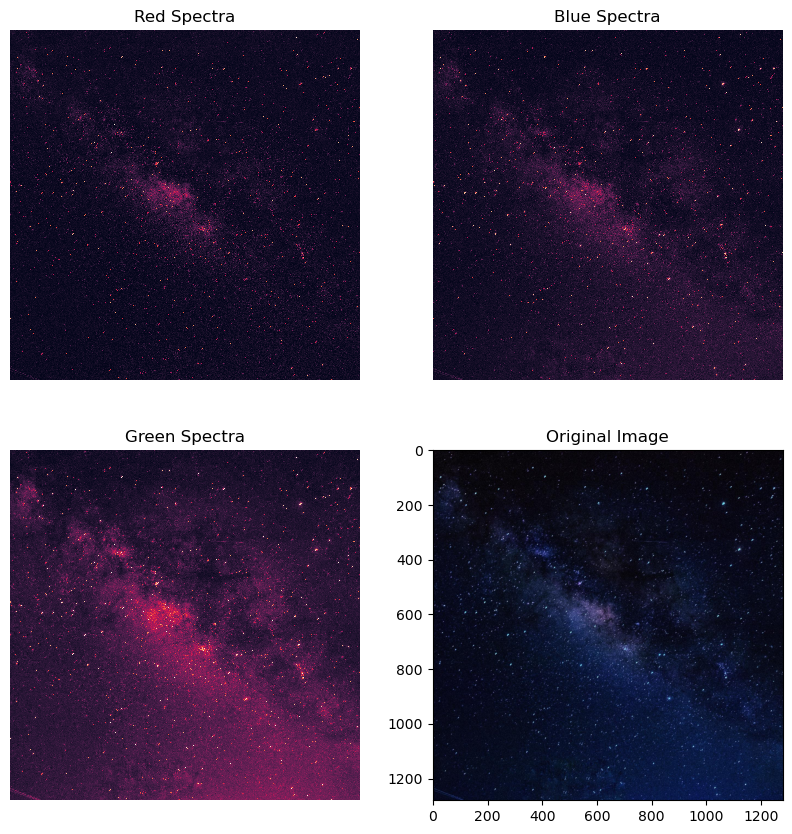

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
titles= ["Red Spectra", "Blue Spectra","Green Spectra", "Original Image"]
for i, ax in enumerate(axs.flat):
    try:
        sns.heatmap(array[:,:,i], square=True, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
        ax.set_title(titles[i])
    except:
        ax.set_title(titles[i])
        image = mpimg.imread(image_path)
        ax.imshow(image)

Generate a list of data points from image and convert to df to begin vanilla preprocessing.

In [4]:
data = None
columns = ["red", "green", "blue"]

for row in range(len(array)):
    try:
        data = np.append(data, array[row, : , :], axis=0)
    except:
        data = array[row, : , :]
 
scaler = MaxAbsScaler()
scaler.fit(data)
preprocessed_df = pd.DataFrame(scaler.transform(data), columns=columns)

Instantiate the model and dataloader with preprocessed data as a np.array()

In [5]:
anomaly_std_tolerance= 1.2
penalty_ratio=.99
cutoff_distance=100
model = hsa_model.HSA_model(
            penalty_ratio=penalty_ratio,
            cutoff_distance= cutoff_distance,
            converge_toll= 1e-5,
            anomaly_std_tolerance= anomaly_std_tolerance,
            affinity_matrix_iterations= 20,
            lr= 2.7,
            logger=logger,
            multifilter_flag=0,
        )
dataset = hsa_dataset.HSA_dataset(preprocessed_np=preprocessed_df.to_numpy(), logger=logger)
dataloader = DataLoader(dataset, batch_size=10)


In [ ]:
base_directory = "Images/"
log_directory = f"{base_directory}/logs/"
results_directory = f"{base_directory}/results/"
model.set_directories(log_directory, results_directory)

logger.info("Starting to run through the dataloader on initial pass.")
batch_size = 1000
unique_id_str = "test"
iterations = 10000

for i, data in enumerate(dataloader):  # setting up gpus
    model.set_trial(i * batch_size, batch_size, unique_id_str)
    # Model set up and weight generation
    model.read_data(
        data_multifilter_df=data.squeeze(0)
    ).vertex_weights_distances().weight_generation().graph_evolution()
    # Training steps
    model.torch_optimize_POF(iterations=iterations)
    # Prediction step
    model.model_predictions(preprocessed_df)
    # Store anomalous predictions throughout all batches for use in multi filter
    try:
        total_anomaly_index = np.append(total_anomaly_index, model.x_label)
    except: 
        total_anomaly_index = model.x_label
    if i > 1000:
        break
        

In [7]:
mix_index, mix_data, anomaly_index = model.global_collect_multifilter_df(
            preprocessed_df.to_numpy(),
            total_anomaly_index[: len(preprocessed_df.to_numpy())].astype(int),mf_batch_size=9 * len(total_anomaly_index),
        )
anomaly_prediction_frequency_df = model.apf_df_generation(anomaly_index)

In [8]:
model.uni_shuffle_multifilter_df(
            mix_index.astype(int), mix_data.astype(int), anomaly_index.astype(int)
        )
mf_data = model.all_data
logger.debug(
    "Anomalous data has been colleted into first multifilter dataset."
)

In [9]:
print(f"Original data input- preprocessed_df: {preprocessed_df.shape} \nFirst rank anomlus predictions- anomaly_prediction_frequency_df:{anomaly_prediction_frequency_df.shape} \nMultifilter data shape- mf_data: {mf_data.shape}")

Original data input- preprocessed_df: (1638400, 3) 
First rank anomlus predictions- anomaly_prediction_frequency_df:(2663, 2) 
Multifilter data shape- mf_data: (26630, 3)


In [ ]:
multi_filters = 30
user_location = model.all_index_user

for mf_n in range(multi_filters):
    batch_dataset = hsa_dataset.HSA_dataset(mf_data, logger)
    batch_loader = DataLoader(
        batch_dataset, batch_size=batch_size, 
    )
    j = 0
    for data in batch_loader:
        # # Set up multi filter model
        MF_model = hsa_model.HSA_model(
            penalty_ratio=penalty_ratio,
            cutoff_distance= cutoff_distance,
            converge_toll= 1e-5,
            anomaly_std_tolerance= anomaly_std_tolerance,
            affinity_matrix_iterations= 20,
            lr= 2.7,
            logger=logger,
            multifilter_flag=1,
        )
        MF_model.set_directories(
            log_directory, results_directory
        )
        MF_model.set_trial(j * len(data), len(data), unique_id_str)
        MF_model.read_data(
            data_multifilter_df=data.squeeze(0)
        ).vertex_weights_distances().weight_generation().graph_evolution()

        # # Train MF_MODEL
        MF_model.torch_optimize_POF(iterations=iterations)
        MF_model.model_predictions(
            preprocessed_df, multifilter_flag=1, user_location=user_location
        )
        j += 1
        if j > 3:
            break
        anomaly_prediction_frequency_df.loc[
            anomaly_prediction_frequency_df["User DF Index"].isin(MF_model.x_label),
            "Anomaly Bin Count",
        ] += 1

        logger.trace(
            f"Multifilter {mf_n} of {multi_filters} multifilters is complete."
        )
        # # Global multifilter
        mix_index, mix_data, anomaly_index = (
            model.global_collect_multifilter_df(
                preprocessed_df.to_numpy(),
                total_anomaly_index[: len(preprocessed_df.to_numpy())].astype(int),
                mf_batch_size=9 * len(total_anomaly_index),
            )
        )
        MF_model.uni_shuffle_multifilter_df(mix_index, mix_data, anomaly_index)
        mf_data = MF_model.all_data
        user_location = MF_model.all_index_user

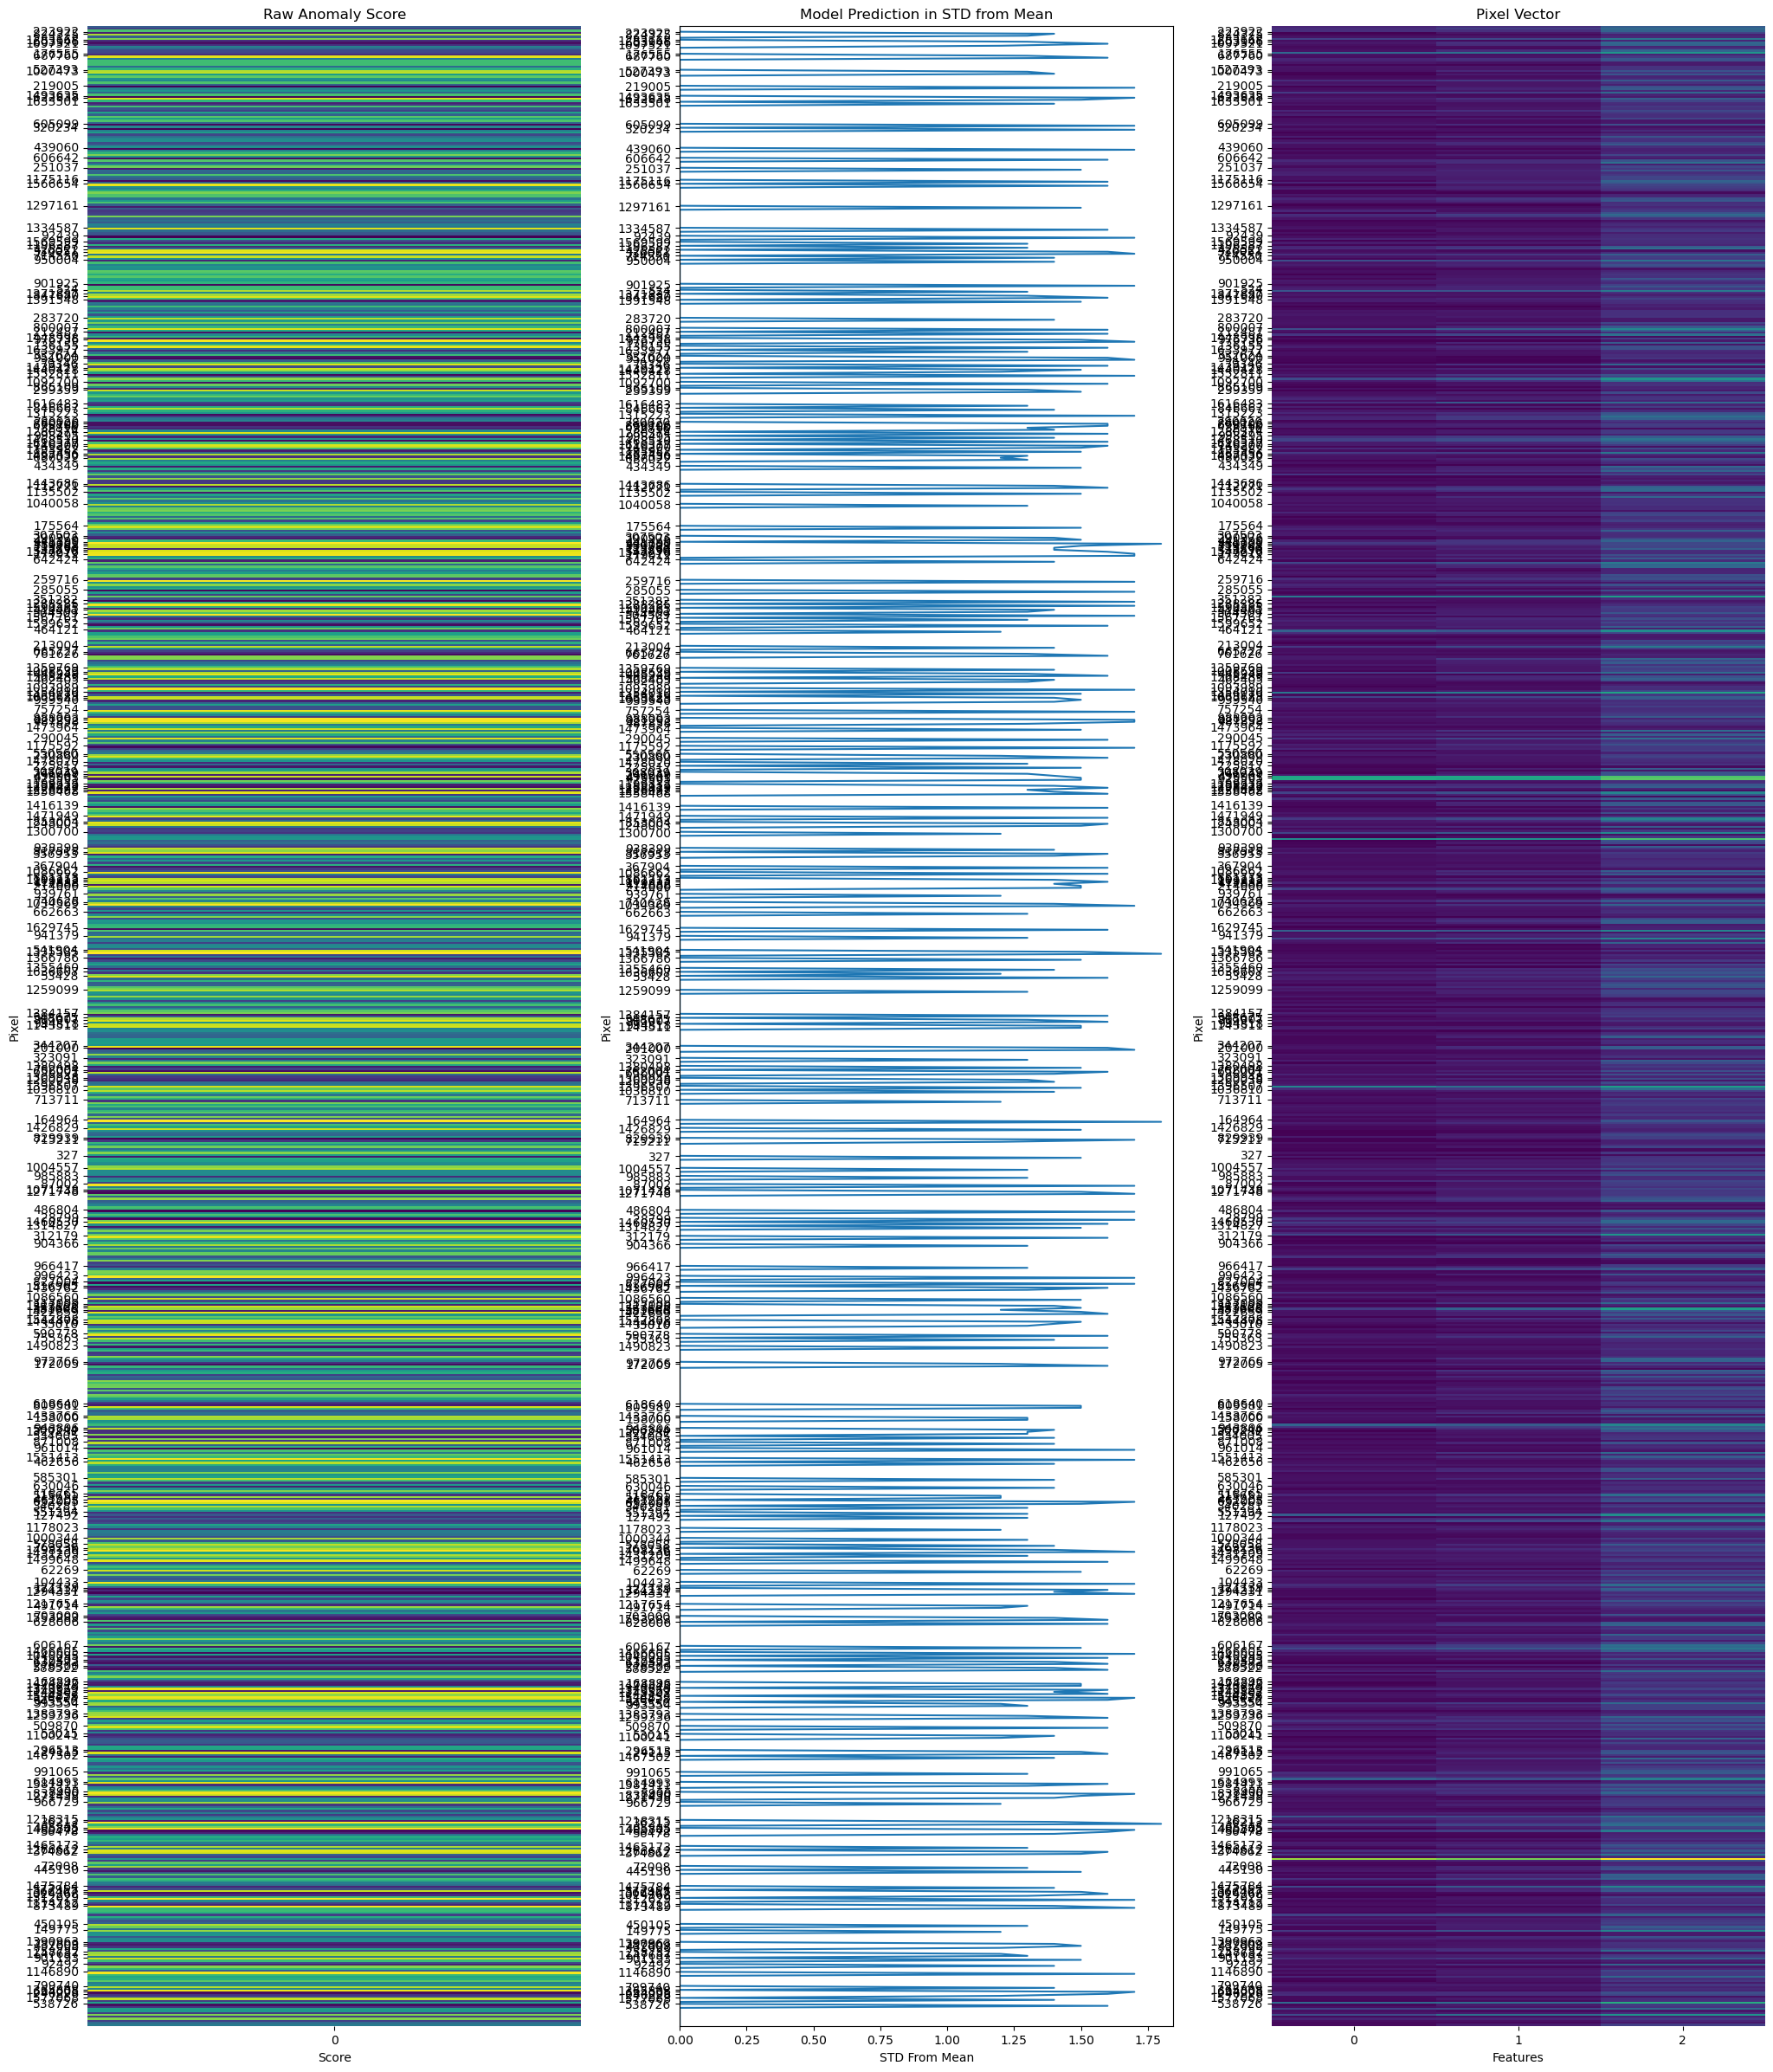

In [12]:
viz = hsa_viz.HSA_viz(
    MF_model.m,
    MF_model.preprocessed_np,
    batch_size,
    0,
    0,
    1,
    0,
    "plot_directory",
    "unique_id_str",
    logger,
)
viz.heatmap_bin_predictions_vert(
    MF_model.bin_score,
    MF_model.anomalous_location,
    MF_model.x_label,
)


In [13]:
preprocessed_df["Anomaly Bin Count"] = np.zeros(len(preprocessed_df))
for i in anomaly_prediction_frequency_df[anomaly_prediction_frequency_df["Anomaly Bin Count"]>0].index:
    preprocessed_df.loc[anomaly_prediction_frequency_df.loc[i], "Anomaly Bin Count"] = anomaly_prediction_frequency_df.loc[i,"Anomaly Bin Count"]  

In [14]:
image_width = 1280
anomaly_score_np = []
for i in range(int(len(preprocessed_df)/image_width)):
    anomaly_score_np.append(preprocessed_df["Anomaly Bin Count"][i*image_width:(1+i)*image_width])

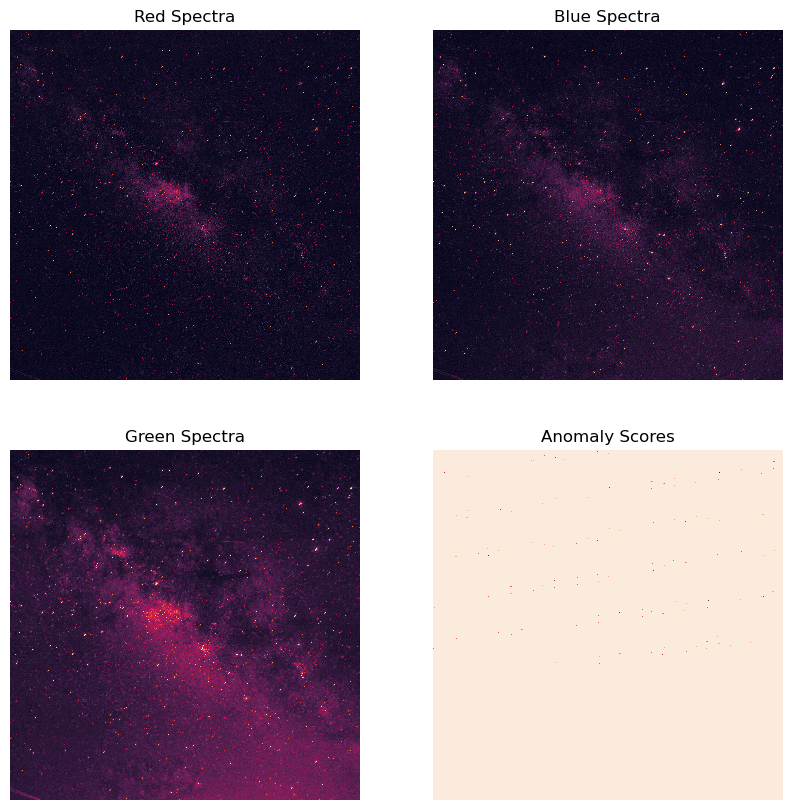

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
titles= ["Red Spectra", "Blue Spectra","Green Spectra", "Anomaly Scores"]
for i, ax in enumerate(axs.flat):
    try:
        sns.heatmap(array[:,:,i], square=True, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
        ax.set_title(titles[i])
    except:
        ax.set_title(titles[i])
        sns.heatmap(anomaly_score_np, square=True, xticklabels=False, yticklabels=False, cbar=False, ax=ax, cmap="rocket_r")
        

Max anomaly score: 6.0
Number of Anomalies:  1769


<Axes: xlabel='Anomaly Bin Count', ylabel='Count'>

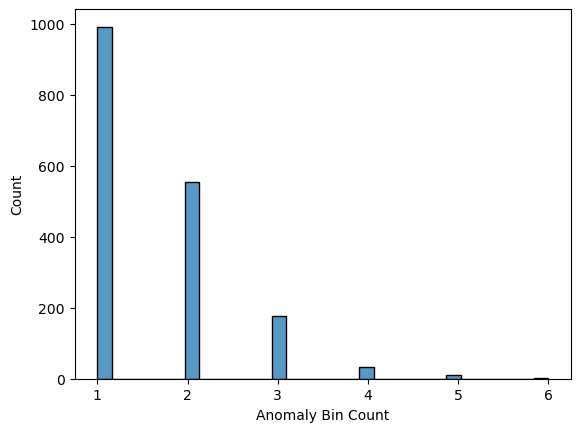

In [16]:
print(f"Max anomaly score: {np.array(anomaly_score_np).max()}")
print(f"Number of Anomalies:  {np.sum(np.greater(np.array(anomaly_score_np), 0))}")
sns.histplot(preprocessed_df.loc[preprocessed_df['Anomaly Bin Count']>0]['Anomaly Bin Count'])